In [1]:
import pickle
import re
import numpy as np
import pandas as pd

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

from mpstemmer import MPStemmer

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

In [3]:
stopwords_ind = stopwords.words('indonesian')

factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemma = MPStemmer()

In [46]:
key_norm = pd.read_csv('../be-sentiment-pk/corpus/colloquial-indonesian-lexicon.csv')

#### **Combine Dataset**

In [275]:
df_smsa = pd.read_csv('../be-sentiment-pk/datasets/ori/indonlu_smsa.csv')

In [283]:
df_synthesized = pd.read_excel('../be-sentiment-pk/datasets/synthesized/synthesized_waste_sentiment.xlsx')

In [276]:
df_smsa.duplicated().sum()

81

In [279]:
df_smsa.drop_duplicates(inplace=True)

In [280]:
df_smsa.duplicated().sum()

0

In [13]:
df_synthesized.duplicated().sum()

0

In [15]:
print(df_smsa.shape)
print(df_synthesized.shape)

(12679, 2)
(12679, 2)


In [18]:
# Menggabungkan kedua DataFrame
df_combined = pd.concat([df_smsa, df_synthesized], ignore_index=True)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [19]:
df_combined.to_csv('../be-sentiment-pk/datasets/combined/waste_sentiment.csv', index=False)

#### **Preprocessing**

In [5]:
df = pd.read_csv('../be-sentiment-pk/datasets/combined/waste_sentiment.csv')

In [45]:
def casefolding(string):
    string = string.lower()
    string = re.sub(r'https?://\S+|www\.\S+', '', string) # remove URLs
    string = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", '', string) # remove punctuations and special characters
    # string = re.sub(r'[^\w\s]','', string) # remove tanda baca
    string = re.sub(r"[^A-Za-z0-9(),!?\'\-`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    # Menghapus enter
    string = re.sub(r"\n", "", string)

    # Membersihkan elemen yang tidak perlu, seperti menghapus spasi 2
    string = re.sub(r"\'re", " \'re", string)

    # Mengecek digit atau bukan
    string = re.sub(r"\'d", " \'d", string)

    # Mengecek long atau bukan
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.strip()
    # Menghilangkan imbuhan
    
    return string

In [47]:
def text_normalize(string):
    words = string.split()
    normalized_text = ' '.join([key_norm[key_norm['slang'] == word]['formal'].values[0] if (key_norm['slang'] == word).any() else word for word in words])
    return normalized_text.lower()

In [131]:
# Stopword remover setup
stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover = StopWordRemover(new_array)

def remove_stopwords(text):
    return stop_words_remover.remove(text)

In [132]:
def stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [133]:
def lemmatization(text):
    return lemma.stem(text)

In [11]:
df['cleaned_text'] = df['text'].apply(lambda x: casefolding(x))

In [12]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: text_normalize(x))

In [13]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_stopwords(x))

In [14]:
df['cleaned_text'] = df['cleaned_text'].apply(stemming)

In [15]:
df['preprocessed_text'] = df['cleaned_text'].apply(lemmatization)

In [16]:
df.to_csv('../be-sentiment-pk/datasets/preprocessed/waste_sentiment_cleaned.csv', index=False)

In [134]:
df = pd.read_csv('../be-sentiment-pk/datasets/preprocessed/waste_sentiment_cleaned.csv')

In [3]:
df = pd.read_csv('../be-sentiment-pk/datasets/synthesized/synthesized_waste_sentiment_cleaned.csv')

In [4]:
df = df.drop(['text', 'cleaned_text'], axis=1)

In [5]:
sentiments = df[['label']]

# Menginisialisasi dan menerapkan OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_sentiments = encoder.fit_transform(sentiments)

In [6]:
print(encoded_sentiments)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [19]:
encoded_df = pd.DataFrame(encoded_sentiments, columns=encoder.categories_[0])

# Concatenate the encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

# Display the DataFrame with encoded sentiments
print(df_encoded.iloc[1])

label                                                          neutral
preprocessed_text    perlu ada koordinasi lebih baik tugas bersih m...
negative                                                           0.0
neutral                                                            1.0
positive                                                           0.0
Name: 1, dtype: object


In [7]:
# Tokenisasi teks
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['preprocessed_text'].values)
sequences = tokenizer.texts_to_sequences(df['preprocessed_text'].values)

# Padding sequences agar memiliki panjang yang sama
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Menampilkan hasil
print(padded_sequences)

[[  0   0   0 ...   1  18 129]
 [  0   0   0 ...   3   1  15]
 [  0   0   0 ...  23   4   9]
 ...
 [  0   0   0 ... 331   1  36]
 [  0   0   0 ...  23   8 220]
 [  0   0   0 ...  23 422  27]]


#### **Extraction Feature & Modeling**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_sentiments, test_size=0.2, random_state=42)

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
# Parameter model
vocab_size = len(tokenizer.word_index) + 1  # Ditambah 1 untuk padding token
embedding_dim = 100
max_length = 200  # Tetapkan max_length sesuai dengan padding sequence

def create_model():
    # Membuat model
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim), # mengubah representasi kata menjadi vektor dengan dimensi tetap, sebagai featurenya berbentuk vector
        Bidirectional(LSTM(units=32, dropout=0.5)),
        Dense(units=3, activation='softmax')
    ])

    # Kompilasi model
    model.compile(
        loss='categorical_crossentropy', # ketika menggunakan ordinal encoder maka gunakan sparse_categorical_crossentropy, kalau menggunakan one-hot encoder maka menggunakan categorical_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    # Membangun model
    model.build(input_shape=(None, max_length)) # untuk menggunakan embedding

    # Menampilkan ringkasan model setelah memberikan contoh data untuk menentukan bentuk layer
    model.summary()

    return model

##### **Experiment**

In [173]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Create the model
model_test = create_model()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │       373,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 408,143 (1.56 MB)

 Trainable params: 408,143 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    '../be-sentiment-pk/model/bilstm_fix/best_model19.keras',         # File path to save the model
    monitor='val_loss',      # Metric to monitor
    save_best_only=True,      # Save only the best model
    mode='min',              # Save the model with the minimum value of the monitored metric
    verbose=1                # Print log messages
)

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=3,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

# Train the model with the callbacks
history_test = model_test.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.6824 - loss: 0.7105 - val_accuracy: 0.9360 - val_loss: 0.1956
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.9450 - loss: 0.1690 - val_accuracy: 0.9527 - val_loss: 0.1453
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9654 - loss: 0.1037 - val_accuracy: 0.9517 - val_loss: 0.1399
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.9719 - loss: 0.0873 - val_accuracy: 0.9507 - val_loss: 0.1341
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9776 - loss: 0.0660 - val_accuracy: 0.9537 - val_loss: 0.1466
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9807 - loss: 0.0615 - val_accuracy: 0.9567 - val_loss: 0.1440
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9865 - loss: 0.0439 - val_accuracy: 0.9576 - val_loss: 0.1457


In [19]:
# units=32, batch_size=128, validation_split=0.2
loss_test, accuracy_test = model_test.evaluate(X_test, y_test)
print(f"Validation Loss: {loss_test}")
print(f"Test Accuracy: {accuracy_test}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9564 - loss: 0.1293
Validation Loss: 0.14214162528514862
Test Accuracy: 0.9562302827835083


##### **FIX**

In [77]:
# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    '../be-sentiment-pk/model/bilstm_fix/best_model11.keras',         # File path to save the model
    monitor='val_loss',      # Metric to monitor
    save_best_only=True,      # Save only the best model
    mode='min',              # Save the model with the minimum value of the monitored metric
    verbose=1                # Print log messages
)

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=3,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7815 - loss: 0.5322
Epoch 1: val_loss improved from inf to 0.25603, saving model to ../be-sentiment-pk/model/bilstm_fix/best_model.keras
571/571 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.7816 - loss: 0.5319 - val_accuracy: 0.9073 - val_loss: 0.2560
Epoch 2/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9309 - loss: 0.1928
Epoch 2: val_loss did not improve from 0.25603
571/571 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - accuracy: 0.9309 - loss: 0.1928 - val_accuracy: 0.9118 - val_loss: 0.2686
Epoch 3/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9514 - loss: 0.1353
Epoch 3: val_loss did not improve from 0.25603
571/571 ━━━━━━━━━━━━━━━━━━━━ 49s 86ms/step - accuracy: 0.9514 - loss: 0.1353 - val_accuracy: 0.9044 - val_loss: 0.2816
Epoch 4/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9633 - loss: 0.1017
Epoch 4: val_loss did not improve from 0.25603
571/571 ━━━━━━━━━━━━━━━━━━━━ 78s 78

In [78]:
# batch_size=64, validation_split=0.1
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9125 - loss: 0.2363
Validation Loss: 0.23696446418762207
Test Accuracy: 0.9106861352920532


In [45]:
# Train and evaluate the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 79s 131ms/step - accuracy: 0.7841 - loss: 0.5287 - val_accuracy: 0.9039 - val_loss: 0.2628
Epoch 2/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 58s 102ms/step - accuracy: 0.9359 - loss: 0.1793 - val_accuracy: 0.9073 - val_loss: 0.2682
Epoch 3/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.9527 - loss: 0.1372 - val_accuracy: 0.9039 - val_loss: 0.2894
Epoch 4/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - accuracy: 0.9650 - loss: 0.1015 - val_accuracy: 0.9024 - val_loss: 0.2933


In [46]:
# batch_size=64, validation_split=0.1
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9146 - loss: 0.2383
Validation Loss: 0.2445911169052124
Test Accuracy: 0.9100946187973022


#### **Evaluasi Model**

In [11]:
model = load_model('../be-sentiment-pk/models/bilstm_fix/model_bilstm_fix3.keras')

In [37]:
# Evaluasi model pada set pelatihan
train_loss, train_accuracy = model_test.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Prediksi label untuk set pelatihan
y_train_pred = model.predict(X_train)

# Menghasilkan label prediksi menggunakan argmax
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Mengonversi y_train_pred_classes ke bentuk one-hot encoding untuk perbandingan yang sesuai
y_train_pred_onehot = np.zeros_like(y_train_pred)
y_train_pred_onehot[np.arange(len(y_train_pred)), y_train_pred_classes] = 1

# Menghasilkan laporan klasifikasi untuk set pelatihan
train_report = classification_report(y_train, y_train_pred_onehot, target_names=['negative', 'neutral', 'positive'])
print("Training Classification Report:\n", train_report)


317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9802 - loss: 0.0617
Training Accuracy: 97.62%
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Training Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.99      0.97      3234
     neutral       0.95      0.89      0.92      1087
    positive       0.99      0.99      0.99      5822

   micro avg       0.98      0.98      0.98     10143
   macro avg       0.97      0.95      0.96     10143
weighted avg       0.98      0.98      0.98     10143
 samples avg       0.98      0.98      0.98     10143



In [43]:
# Evaluasi model pada set pengujian
loss, accuracy = model_test.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Prediksi label untuk set pengujian
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengonversi y_pred_classes ke bentuk one-hot encoding
y_pred_onehot = np.zeros_like(y_pred)
y_pred_onehot[np.arange(len(y_pred)), y_pred_classes] = 1

# Pastikan y_test adalah array 1 dimensi (bukan one-hot encoding)
y_test_classes = np.argmax(y_test, axis=1) if y_test.shape[1] > 1 else y_test
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print('\nConfusion Matrix:\n', conf_matrix)

# Menghasilkan laporan klasifikasi untuk set pengujian
test_report = classification_report(y_test, y_pred_onehot, target_names=['negative', 'neutral', 'positive'])
print("\nTesting Classification Report:\n", test_report)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9564 - loss: 0.1293
Test Accuracy: 95.62%
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Confusion Matrix:
 [[ 751   12    8]
 [  37  217   14]
 [  29   11 1457]]

Testing Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.97      0.95       771
     neutral       0.90      0.81      0.85       268
    positive       0.99      0.97      0.98      1497

   micro avg       0.96      0.96      0.96      2536
   macro avg       0.94      0.92      0.93      2536
weighted avg       0.96      0.96      0.96      2536
 samples avg       0.96      0.96      0.96      2536



In [38]:
# Evaluasi model pada set pengujian
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Prediksi label untuk set pengujian
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengonversi y_pred_classes ke bentuk one-hot encoding
y_pred_onehot = np.zeros_like(y_pred)
y_pred_onehot[np.arange(len(y_pred)), y_pred_classes] = 1

# Menghasilkan laporan klasifikasi untuk set pengujian
test_report = classification_report(y_test, y_pred_onehot, target_names=['negative', 'neutral', 'positive'])
print("Testing Classification Report:\n", test_report)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9564 - loss: 0.1293
Test Accuracy: 95.62%
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Testing Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.97      0.95       771
     neutral       0.90      0.81      0.85       268
    positive       0.99      0.97      0.98      1497

   micro avg       0.96      0.96      0.96      2536
   macro avg       0.94      0.92      0.93      2536
weighted avg       0.96      0.96      0.96      2536
 samples avg       0.96      0.96      0.96      2536



In [39]:
# Pastikan y_test adalah array 1 dimensi (bukan one-hot encoding)
y_test_classes = np.argmax(y_test, axis=1) if y_test.shape[1] > 1 else y_test

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print('\nConfusion Matrix:\n', conf_matrix)


Confusion Matrix:
 [[ 751   12    8]
 [  37  217   14]
 [  29   11 1457]]


In [32]:
import re

# Function to preprocess text
def preprocess_text(text):
    # text = re.sub(r'\bsampah\b', 'sampahnya', text)
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = lemmatization(text)
    return text

# Example usage
feedback = input("Your Feedback:")
feedback_processed = preprocess_text(feedback)

# Example new data to predict
new_texts = [feedback_processed]

# Tokenize new data
sequences_predict = tokenizer.texts_to_sequences(new_texts)

# Padding sequences
max_length = 100  # Adjust according to your model's max_length
padded_sequences_predict = pad_sequences(sequences_predict, maxlen=max_length)

# Load the saved model
# model = load_model('../model/bilstm/model_bilstm3.keras')

# Perform prediction
predictions = model.predict(padded_sequences_predict)

# Example of printing predictions
for text, prediction in zip(new_texts, predictions):
    print(f'Text: {feedback}')
    print(f'Prediction: {prediction}')

    # Find the index of the maximum value
    if np.argmax(prediction) == 0:
        print("Sentiment: negative")
    elif np.argmax(prediction) == 1:
        print("Sentiment: neutral")
    elif np.argmax(prediction) == 2:
        print("Sentiment: positive")

    # Find the maximum value in the prediction array
    max_value = max(prediction)
    print(f'Highest Score: {max_value}')

    print(f'Score Negative: {prediction[0]}')
    print(f'Score Neutral: {prediction[1]}')
    print(f'Score Positive: {prediction[2]}')
    print()  # For spacing between outputs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Text: tempat sampah bocor
Prediction: [0.7825986  0.1142235  0.10317788]
Sentiment: negative
Highest Score: 0.782598614692688
Score Negative: 0.782598614692688
Score Neutral: 0.11422350257635117
Score Positive: 0.10317787528038025



#### **Model SVM**

In [224]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

In [225]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC())
])

In [226]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=1, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

In [227]:
# Menampilkan 10 kata dengan nilai IDF tertinggi
freqs = tfidf_matrix.sum(axis=0)
idf_values = tfidf_vectorizer.idf_
word_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), idf_values))

top_idf_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf in top_idf_words:
    print(f'Kata: {word}, Nilai IDF: {idf}')

Kata: 00 ib, Nilai IDF: 10.447741795037093
Kata: 00 private, Nilai IDF: 10.447741795037093
Kata: 00 si, Nilai IDF: 10.447741795037093
Kata: 000 banyak, Nilai IDF: 10.447741795037093
Kata: 000 bunda, Nilai IDF: 10.447741795037093
Kata: 000 datang, Nilai IDF: 10.447741795037093
Kata: 000 hingga, Nilai IDF: 10.447741795037093
Kata: 000 kamu, Nilai IDF: 10.447741795037093
Kata: 000 layan, Nilai IDF: 10.447741795037093
Kata: 000 per, Nilai IDF: 10.447741795037093


In [228]:
X_train_idf, X_test_idf, y_train_idf, y_test_idf = train_test_split(tfidf_matrix, df['label'], test_size=0.2, random_state=42)

model = svm.SVC(C=2, kernel='rbf', gamma=0.5)
model.fit(X_train_idf, y_train_idf)
print(f"Accuracy : {model.score(X_test_idf, y_test_idf)}")

Accuracy : 0.9148264984227129


In [229]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [230]:
# Evaluasi model pada training
y_train_pred_idf = model.predict(X_train_idf)
train_accuracy_idf = accuracy_score(y_train_idf, y_train_pred_idf)

print("Training Accuracy:", train_accuracy_idf)
print("Training Classification Report:")
print(classification_report(y_train_idf, y_train_pred_idf))

Training Accuracy: 0.9933451641526175
Training Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      6442
     neutral       1.00      0.99      1.00      2171
    positive       0.99      0.99      0.99     11673

    accuracy                           0.99     20286
   macro avg       0.99      0.99      0.99     20286
weighted avg       0.99      0.99      0.99     20286



In [231]:
# Evaluasi model pada testing
y_test_pred_idf = model.predict(X_test_idf)
test_accuracy_idf = accuracy_score(y_test_idf, y_test_pred_idf)

print("Testing Accuracy:", test_accuracy_idf)
print("Testing Classification Report:")
print(classification_report(y_test_idf, y_test_pred_idf))

Testing Accuracy: 0.9148264984227129
Testing Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.90      0.89      1568
     neutral       0.89      0.72      0.79       539
    positive       0.94      0.96      0.95      2965

    accuracy                           0.91      5072
   macro avg       0.90      0.86      0.88      5072
weighted avg       0.91      0.91      0.91      5072



In [233]:
import joblib

In [234]:
joblib.dump(model, '../be-sentiment-pk/utils/sentiment.pkl')
joblib.dump(tfidf_vectorizer, '../be-sentiment-pk/utils/tfidf_vectorizer.pkl')

['../be-sentiment-pk/utils/tfidf_vectorizer.pkl']

#### **Save Model**

In [23]:
# Save the model as an keras file
model_test.save('../be-sentiment-pk/fix/model_final.keras')

In [22]:
# Simpan history ke file pickle
with open('../be-sentiment-pk/fix/history_final.pkl', 'wb') as file:
    pickle.dump(history_test.history, file)

In [24]:
# Save the model weights
model_test.save_weights('../be-sentiment-pk/fix/model_weights_final.weights.h5')

In [26]:
# Save the model as a PKL file
# Save the model architecture as a JSON string
model_json = model_test.to_json()
with open('../be-sentiment-pk/fix/model_architecture_final.json', 'w') as json_file:
    json_file.write(model_json)

In [27]:
# Save the model as a pickle file
with open('../be-sentiment-pk/fix/model_final.pkl', 'wb') as pkl_file:
    pickle.dump({'../be-sentiment-pk/fix/model_architecture_final': model_json, '../be-sentiment-pk/fix/model_weights_final': model.get_weights()}, pkl_file)

In [28]:
# Save tokenizer's word index
with open('../be-sentiment-pk/fix/tokenizer_word_index_final.pkl', 'wb') as f:
    pickle.dump(tokenizer.word_index, f)

# Save tokenizer's configuration
tokenizer_config = {
    'num_words': tokenizer.num_words,
    'filters': tokenizer.filters,
    'lower': tokenizer.lower,
    'split': tokenizer.split,
    'char_level': tokenizer.char_level,
    'oov_token': tokenizer.oov_token,
    'document_count': tokenizer.document_count
}

with open('../be-sentiment-pk/fix/tokenizer_config_final.pkl', 'wb') as f:
    pickle.dump(tokenizer_config, f)

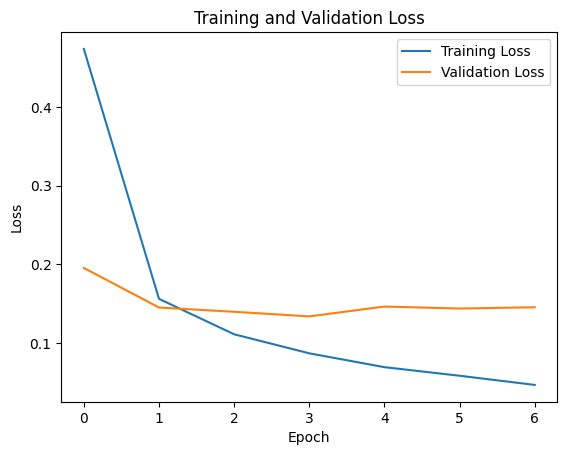

In [40]:
# Memuat history dari file pickle
with open('../be-sentiment-pk/fix/history_final.pkl', 'rb') as file:
    history = pickle.load(file)

# Membuat grafik loss
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

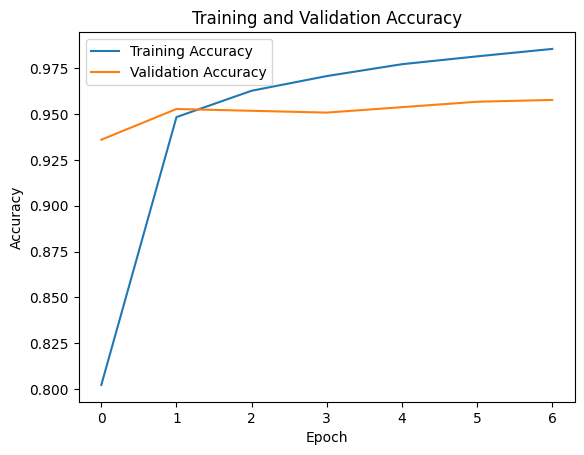

In [41]:
# Memuat history dari file pickle
with open('../be-sentiment-pk/fix/history_final.pkl', 'rb') as file:
    history = pickle.load(file)

# Membuat grafik loss
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### **Load Model**

In [62]:
model_lstm = load_model('../utils/sentiment.pkl')

In [ ]:
# Ekstraksi fitur dari model LSTM untuk data latih dan uji
X_train_features = model_lstm.predict(X_train)
X_test_features = model_lstm.predict(X_test)

# Inisialisasi dan latih model SVM
model_svm = svm.SVC(C=1.5, kernel='linear', gamma=1)
model_svm.fit(X_train_features, y_train2)

# Prediksi menggunakan model gabungan LSTM-SVM
y_pred = model_svm.predict(X_test_features)

# Evaluasi
print("Accuracy:", accuracy_score(y_test2, y_pred))
print("Classification Report:\n", classification_report(y_test2, y_pred))

In [34]:
# model19 = load_model('./models/word2vec_bilstm/model_word2vec_bilstm.keras')
model = load_model('../be-sentiment-pk/fix/model_final.keras')

In [35]:
loss19, accuracy19 = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss19}")
print(f"Test Accuracy: {accuracy19}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9564 - loss: 0.1293
Validation Loss: 0.14214162528514862
Test Accuracy: 0.9562302827835083


In [66]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Evaluasi pada training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluasi pada testing set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

In [69]:
import re

# Function to preprocess text
def preprocess_text(text):
    # text = re.sub(r'\bsampah\b', 'sampahnya', text)
    text = re.sub(r'\blayak\b', 'dapat', text)
    text = casefolding(text)
    text = text_normalize(text)
    return text

# Example usage
feedback = input("Your Feedback:")
feedback_processed = preprocess_text(feedback)

# Load tokenizer's configuration
# with open('../be-sentiment-pk/models/asli_fix/tokenizer_config_w2v_bilstm_fix.pkl', 'rb') as f:
# with open('../be-sentiment-pk/models/bilstm_fix/tokenizer_config_bilstm_fix3.pkl', 'rb') as f:
with open('../be-sentiment-pk/fix/tokenizer_config_final.pkl', 'rb') as f:
    tokenizer_config = pickle.load(f)

# Recreate tokenizer
tokenizer = Tokenizer(**tokenizer_config)

# Load tokenizer's word index
# with open('../be-sentiment-pk/models/bilstm_fix/tokenizer_word_index_bilstm_fix3.pkl', 'rb') as f:
with open('../be-sentiment-pk/fix/tokenizer_word_index_final.pkl', 'rb') as f:
    tokenizer.word_index = pickle.load(f)

# Example new data to predict
new_texts = [feedback_processed]

# Tokenize new data
sequences = tokenizer.texts_to_sequences(new_texts)

# Padding sequences
max_length = 100  # Adjust according to your model's max_length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Load the saved model
# model_nih = load_model('../be-sentiment-pk/models/bilstm_fix/best_model3.keras')
model_nih = load_model('../be-sentiment-pk/fix/model_final.keras')

# Perform prediction
predictions = model_nih.predict(padded_sequences)

# Example of printing predictions
for text, prediction in zip(new_texts, predictions):
    print(f'Text: {feedback_processed}')
    print(f'Prediction: {prediction}')

    # Find the index of the maximum value
    if np.argmax(prediction) == 0:
        print("Sentiment: negative")
    elif np.argmax(prediction) == 1:
        print("Sentiment: neutral")
    elif np.argmax(prediction) == 2:
        print("Sentiment: positive")

    # Find the maximum value in the prediction array
    max_value = max(prediction)
    print(f'Highest Score: {max_value}')

    print(f'Score Negative: {prediction[0]}')
    print(f'Score Neutral: {prediction[1]}')
    print(f'Score Positive: {prediction[2]}')
    print()  # For spacing between outputs


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Text: tempat sampah tidak dapat digunakna
Prediction: [0.9566494  0.03753969 0.00581088]
Sentiment: negative
Highest Score: 0.9566494226455688
Score Negative: 0.9566494226455688
Score Neutral: 0.037539687007665634
Score Positive: 0.005810883361846209

